In [1]:
import argparse
import warnings
from datetime import datetime
from glob import glob
from shutil import copyfile
from collections import OrderedDict
from PIL import Image
from IPython.display import display

import torch
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

from models.generator import Generator as Generator
from tools.utils import *
from main import clip_load_model

from clipfont import clip

clip_model_name = 'ViT-B/32'
clip_model, clip_preprocess = clip.load(clip_model_name, device="cuda")

In [2]:
def get_transform(img_size=80, input_ch=1):
  if input_ch == 1:
      mean = [0.5]
      std = [0.5]
  else:
      mean = [0.5, 0.5, 0.5]
      std = [0.5, 0.5, 0.5]
  
  normalize = Normalize(mean=mean, std=std)
  transform = Compose([Resize((img_size, img_size)),
                        ToTensor(),
                        normalize])
  return transform

transform = get_transform()

In [3]:
def build_model(img_size=80, sty_dim=512, input_ch=1, device='cuda'):
    networks = {}
    networks['G'] = Generator(
        img_size,
        sty_dim,
        use_sn=False,
        device=device,
        input_ch=input_ch,
        output_ch=input_ch)
    networks['G_EMA'] = Generator(
        img_size,
        sty_dim,
        use_sn=False,
        device=device,
        input_ch=input_ch,
        output_ch=input_ch)

    if device is not None:
        # torch.cuda.set_device(args.device)
        for name, net in networks.items():
            # networks[name] = net.cuda(args.gpu)
            # networks[name] = net.cuda(args.device)
            networks[name] = net.to(device)
    return networks

In [4]:
def clip_load_model(
    model,
    checkpoint_path=None,
    requires_grad=False,
    device='cuda',
    model_name='ViT-B/32',
):
    if checkpoint_path is None:
        model, _ = clip.load(model_name, device=device, jit=False)
    else:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])

    if not requires_grad:
        for param in model.parameters():
            param.requires_grad = False
    return model

def load_model(networks, checkpoint_path=None, log_dir=None):
    if checkpoint_path is not None:
        load_file_path = checkpoint_path
    elif log_dir is not None:
        check_load = open(os.path.join(log_dir, "checkpoint.txt"), 'r')
        to_restore = check_load.readlines()[-1].strip()
        load_file_path = os.path.join(log_dir, to_restore)
    else:
        print("=> no checkpoint found at '{}'".format(log_dir))
        return

    if os.path.isfile(load_file_path):
        print("=> loading checkpoint '{}'".format(load_file_path))
        checkpoint = torch.load(load_file_path, map_location='cpu')
        for name, net in networks.items():
            tmp_keys = next(
                iter(checkpoint[name + '_state_dict'].keys()))
            if 'module' in tmp_keys:
                tmp_new_dict = OrderedDict()
                for key, val in checkpoint[name +
                                           '_state_dict'].items():
                    tmp_new_dict[key[7:]] = val
                net.load_state_dict(tmp_new_dict)
                networks[name] = net
            else:
                net.load_state_dict(checkpoint[name + '_state_dict'])
                networks[name] = net

        print("=> loaded checkpoint '{}' (epoch {})"
              .format(load_file_path, checkpoint['epoch']))

In [9]:
networks = build_model()
model_name = 'GAN_20230902-212445'
model_name = 'GAN_20230903-141844'
log_dir = os.path.join('./logs', model_name)
checkpoint_path = os.path.join(log_dir, 'model_1.ckpt')
load_model(networks, checkpoint_path=checkpoint_path)
# load_model(networks, log_dir=log_dir)
G = networks['G']

Init Generator
GENERATOR NF :  64
Init ContentEncoder
Init Decoder
Init Generator
GENERATOR NF :  64
Init ContentEncoder
Init Decoder
=> loading checkpoint './logs/GAN_20230903-141844/model_1.ckpt'
=> loaded checkpoint './logs/GAN_20230903-141844/model_1.ckpt' (epoch 1)


In [10]:
clip_model_path = '/home/yuki/learn-computer-vision/CLIPFont/model_checkpoints/best_mixed_ViT-B_32_9101191011_batch32_single_character_use_negative_use_negative_loss1e-06_lr2e-05-0.1.pt'
# clip_model_path = '/home/yuki/learn-computer-vision/CLIPFont/model_checkpoints/2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss1e-06_lr2e-05-0.1_image_file_dir.pt'
clip_model = clip_load_model(clip_model, checkpoint_path=clip_model_path, device='cuda')

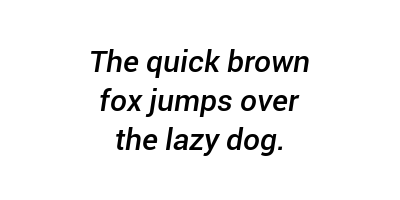

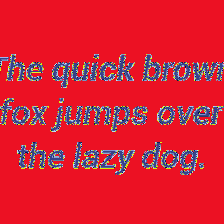

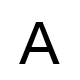

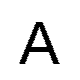

In [11]:
## Style Image
style_image_path = '../attributeData/grayscale_images/Roboto-MediumItalic.png'
# style_image_path = '../attributeData/grayscale_images/Arimo-Bold.png'
style_image = Image.open(style_image_path)
display(style_image)
preprocessed_style_image = clip_preprocess(style_image).unsqueeze(0).to('cuda')
display(to_pil_image(preprocessed_style_image[0]))

## Content Image
content_image_path = '../gwfonts-images-DG-Font/id_0/0000.png'
content_image = Image.open(content_image_path).convert('L')
display(content_image)
transformed_content_image = transform(content_image).unsqueeze(0).to('cuda')
display(to_pil_image(transformed_content_image[0]))

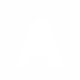

In [12]:
embedded_style_image = clip_model.encode_image(preprocessed_style_image).to(torch.float32)
c_src, skip1, skip2 = G.cnt_encoder(transformed_content_image)
generated_image, _ = G.decode(c_src, embedded_style_image, skip1, skip2)
display(to_pil_image(generated_image[0].cpu()))

In [13]:
generated_image

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.9998, 0.9991, 0.9983],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9998, 0.9995],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9998, 0.9996],
          ...,
          [1.0000, 1.0000, 0.9999,  ..., 0.9999, 0.9997, 0.9991],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9998, 0.9995],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9998, 0.9996]]]],
       device='cuda:0', grad_fn=<TanhBackward0>)